In [1]:
# !python DESOM_train.py --dataset 'im' --save_epochs 10000 --map_size 15 15 --ae_type 'cnn2D' --ae_epochs 0 --iterations 40000 --som_iterations 40000  --model_batch_size 512 --ae_batch_size 512 --Tmax 12.0 --Tmin .5 --gamma 0.001


In [2]:
# def normalize(x):
#   mean = x.mean()
#   std = x.std()
#   return (x - mean) / std

In [3]:
import os
import matplotlib.pyplot as plt
from astropy import table
import numpy as np

from helpers import desom_model as dm
from helpers import utilities as uti

2024-02-16 18:22:54.209898: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
source_cutouts = np.load('data/JJKSandBox/2022-08-22-AS2_som_cutouts_Norm_M.npy')
sources = table.Table.read('data/JJKSandBox/2022-08-22-AS2.tsv', format='ascii.fixed_width', delimiter='\t')

In [5]:
source_cutouts.shape

(102209, 441)

In [6]:
map_size = (15, 15)
cutout_dimension = int(source_cutouts.shape[1]**0.5)
print(f"Working with SoM Map that is a {map_size} grid, cutouts are {cutout_dimension}x{cutout_dimension} pixels each")
number_of_map_cells = map_size[0] * map_size[1]
print(f"Selecting {number_of_map_cells} random sources to display in map")
source_indices = np.random.choice(source_cutouts.shape[0],  number_of_map_cells)
selected_cutouts = source_cutouts[source_indices]
print(f"Selected {selected_cutouts.shape[0]} cutouts")

Working with SoM Map that is a (15, 15) grid, cutouts are 21x21 pixels each
Selecting 225 random sources to display in map
Selected 225 cutouts


In [7]:
def display_map_of_cutouts(cutouts):
    """
    Expecting that images is an (n*n) x (x*y) shaped data set.  Display an n X n grid of x X y cutout images.
    """
    map_size = int(cutouts.shape[0]**0.5),int(cutouts.shape[0]**0.5)
    
    print(f"Plotting a grid of {map_size[0]}x{map_size[1]} cutouts randomly selected from the {source_cutouts.shape[0]} examples")
    fig, ax = plt.subplots(map_size[0], map_size[1], figsize=(map_size[0], map_size[1]))
    xcount = 1
    ycount = map_size[1]
    for k in range(cutouts.shape[0]):
        cutout = cutouts[k].reshape(cutout_dimension, cutout_dimension)
        # Place the cutout into the correct part of the array of cutouts to display
        ax[k // map_size[1]][k % map_size[1]].imshow(cutout, cmap='gray')
        # remove the ticks so the cutouts are close together
        ax[k // map_size[1]][k % map_size[1]].axes.xaxis.set_ticks([])
        ax[k // map_size[1]][k % map_size[1]].axes.yaxis.set_ticks([])
        # label the verticle axis with cell indices
        if k // map_size[1]==map_size[0]:
            ax[map_size[0]][k % map_size[1]].set_xlabel(xcount)
            xcount+=1
        if k % map_size[1]==0:
            ax[k // map_size[1]][0].set_ylabel(ycount, labelpad=7, rotation='horizontal', va='center')
            ycount-=1
    plt.subplots_adjust(hspace=0.05, wspace=0.05)

Plotting a grid of 15x15 cutouts randomly selected from the 102209 examples


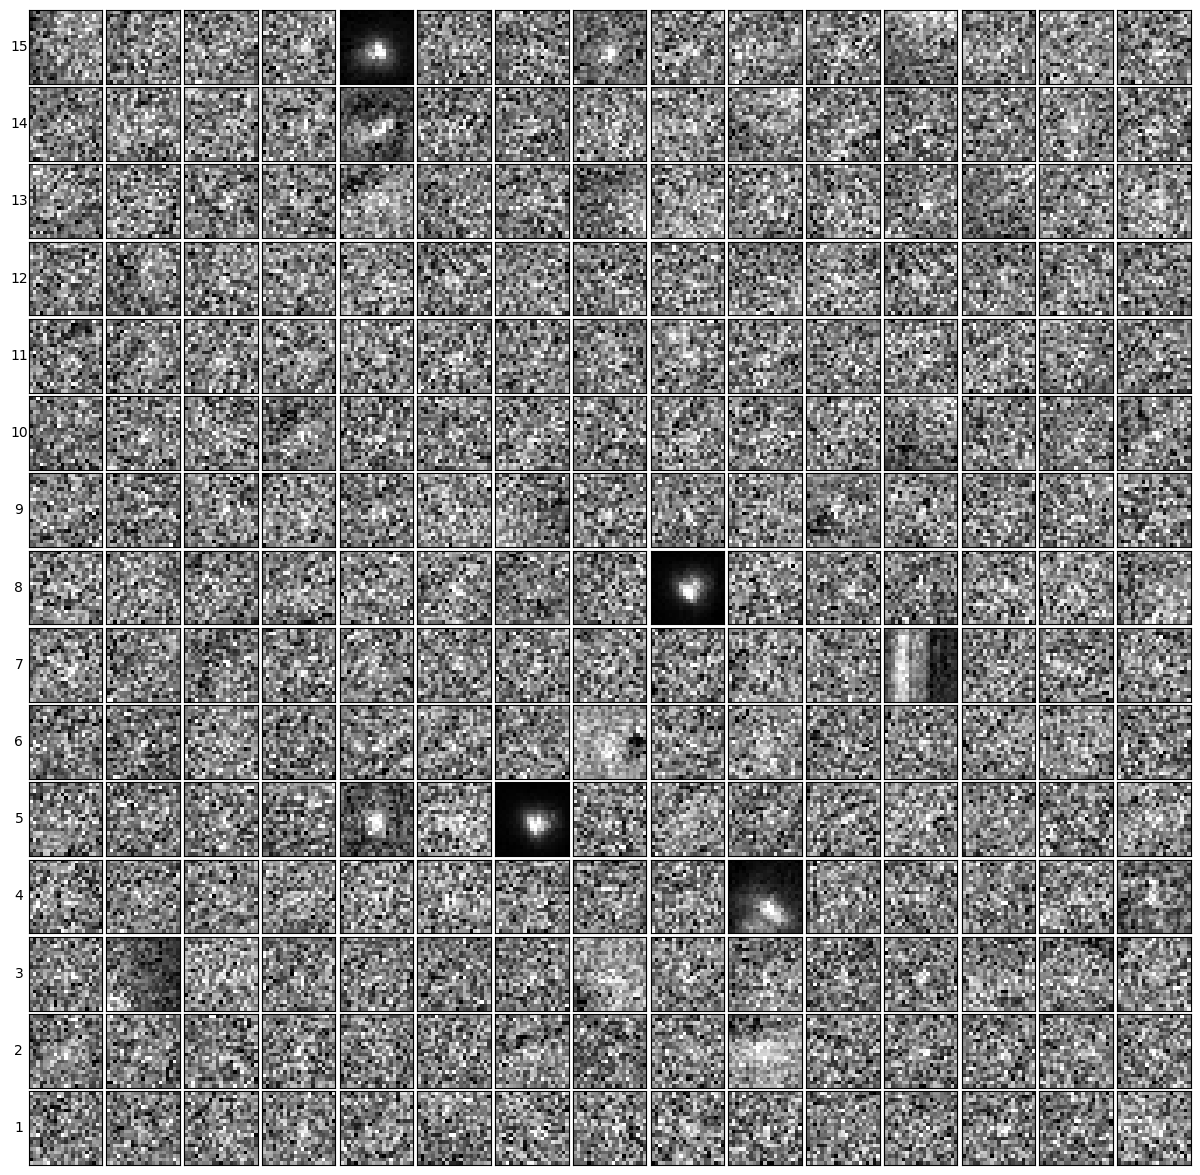

In [8]:
display_map_of_cutouts(selected_cutouts)

In [9]:
# norm_data = []
# for i in data:
#   norm_data.append(normalize(i))

In [10]:
# np.save('images_med_1d_norm', np.array(norm_data))

In [13]:
latent_dim = 32
ae_path = f'results/tmp/ae_weights-epoch0_{latent_dim}M.h5'
model_path = f'results/tmp/DESOM_model_final_{latent_dim}M.h5'

In [14]:
som = dm.load_desom_trained((map_size[0],map_size[1]), 'cnn2D', cutout_dimension, ae_path, model_path, latent_dim=latent_dim)
decoded_prototypes = som.decode(som.prototypes)

Shape before flattening : (2, 2, 128)
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 441)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 21, 21, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 10, 10, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                

Plotting a grid of 15x15 cutouts randomly selected from the 102209 examples


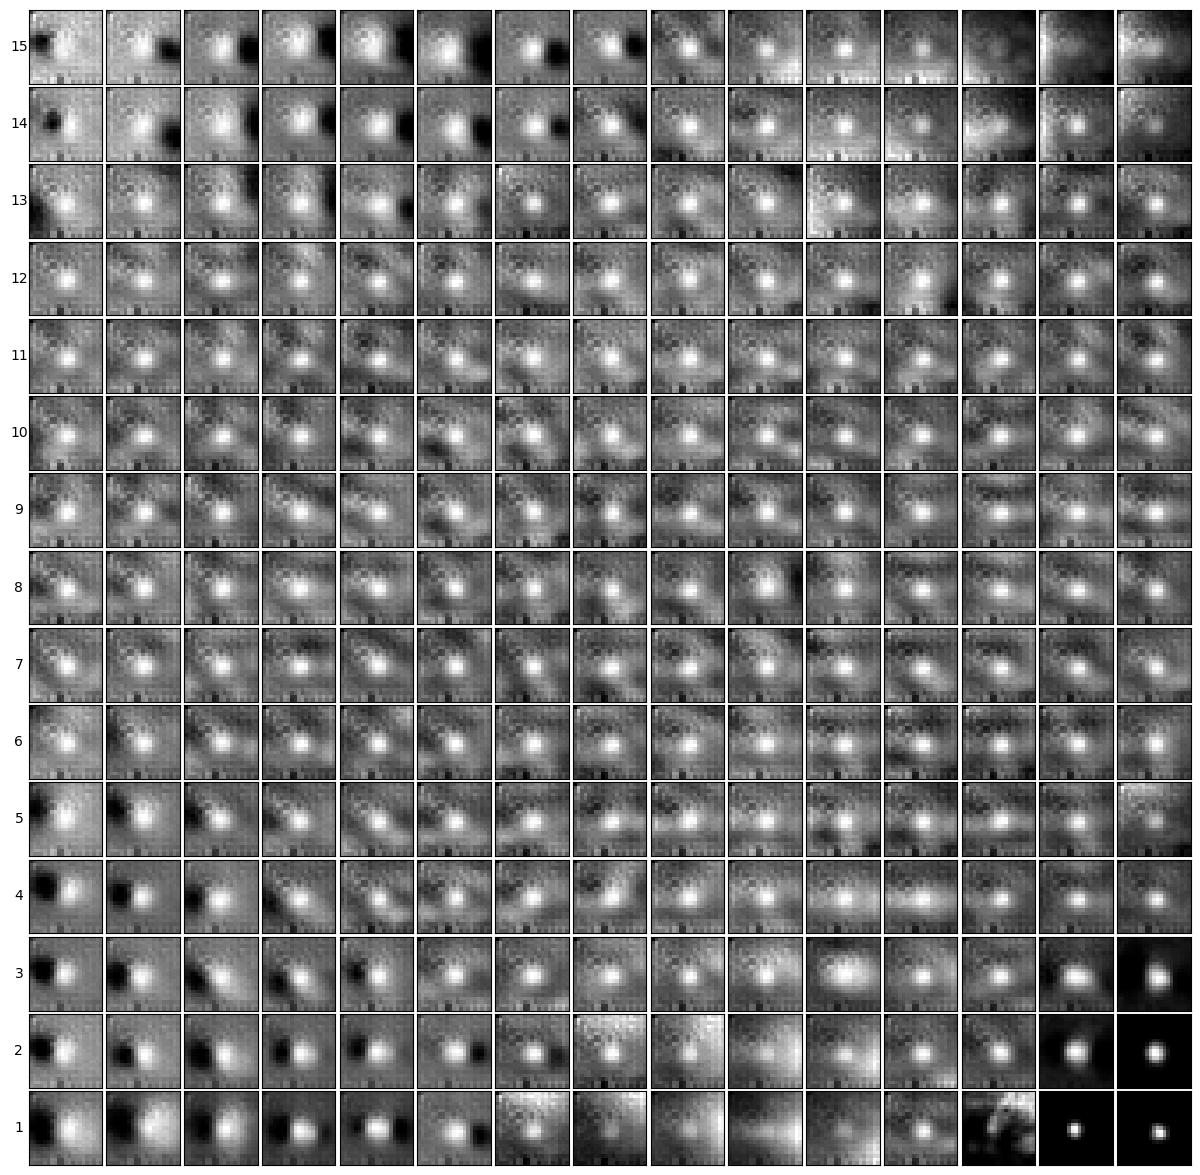

In [15]:
display_map_of_cutouts(decoded_prototypes)

In [16]:
som_indices_of_source_cutouts=som.predict(source_cutouts)

In [17]:
n_cell= map_size[0]*map_size[1]
hit_map1d=np.zeros(n_cell).astype(int)

for k1 in range(len(som_indices_of_source_cutouts)):
    nc = som_indices_of_source_cutouts[k1]
    hit_map1d[nc]+=1

In [18]:

hit_map2d=np.zeros((map_size[0],map_size[1])).astype(int)

n1= 0
for k2 in range(map_size[0]):
    for k1 in range(map_size[1]):            
        hit_map2d[k1,k2] = hit_map1d[n1]
        n1+=1


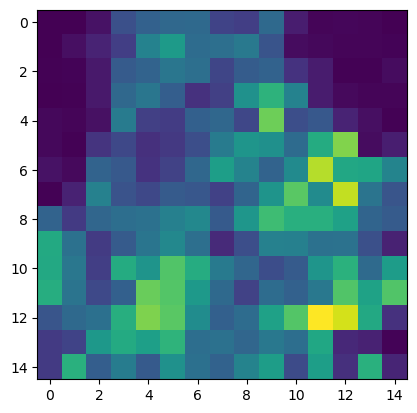

In [19]:
plt.imshow(hit_map2d)

In [20]:
map_size = som.map_size

#A list of NODES
nodes_list = uti.generate_list_of_coords(map_size)
#Disctionaries for FAST conversion
node2idx = uti.get_idx_map(nodes_list, map_size)
idx2node = uti.get_node_map(map_size)


idx_map: maps from NODE to IDX
node_map: maps from IDX to NODE


In [21]:
som_indices_of_source_cutouts[node2idx[14,14]]

88

In [22]:
len(som_indices_of_source_cutouts)

102209

In [23]:
som_indices_of_source_cutouts[~sources['planted'].mask]

array([209, 209, 209, 193, 222, 204, 219, 151, 194,  12, 199, 204, 216,
       190,  13, 126, 205,  94,  73,  49, 102, 133,  44, 188,  62, 119,
        89,  41, 117,  68, 114, 157, 123,  63, 157,  72, 177, 192, 188,
         8, 123, 136, 172, 189,  44, 178,  29,  88,  58, 159,  60, 101,
       130,  46, 173, 205, 202,  55, 133, 178,  57, 161,  90, 145,  55,
        79, 159,  71, 145,  60,  37,  43, 134, 175, 149,  67, 177,  22,
        70, 154, 153, 171,  96,  29, 169, 143, 185, 105,  62,  44,  90,
       157,  56, 123, 138,  66, 141,  42, 144,  61,  11, 187,  73, 101,
       218,  77, 105,  63,  55, 169, 116,  99, 106, 122, 142, 207,  81,
       105, 137, 153, 222,  78,  71,  97, 117, 101,  76,  49, 175,  92,
       121, 125, 220, 163, 164, 188, 123,  78, 145, 189,  60, 143, 192,
        36, 126, 137, 159, 142, 188,  87, 138,  63,  83, 118, 179, 167,
        61, 171,   8, 178,  83,  76, 135, 154,  58, 144,  94,   8,  75,
       171, 163,  46,  95, 140, 174, 138, 185, 131, 187, 138, 15

In [24]:
hit_map2d=np.zeros((map_size[0],map_size[1])).astype(int)
for i in som_indices_of_source_cutouts[~sources['planted'].mask]:
    hit_map2d[idx2node[i]] += 1


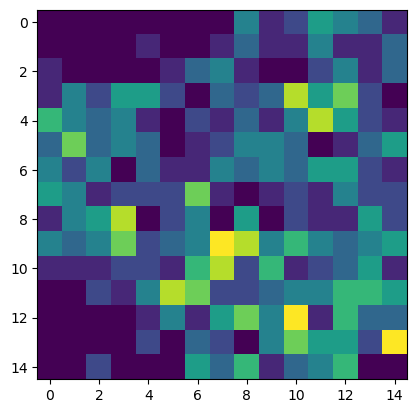

In [25]:
plt.imshow(hit_map2d)

In [26]:
hit_map2d

array([[0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 2, 5, 4, 3, 1],
       [0, 0, 0, 0, 1, 0, 0, 1, 3, 1, 1, 4, 1, 1, 3],
       [1, 0, 0, 0, 0, 1, 3, 4, 1, 0, 0, 2, 4, 1, 3],
       [1, 4, 2, 5, 5, 2, 0, 3, 2, 3, 8, 5, 7, 2, 0],
       [6, 4, 3, 4, 1, 0, 2, 1, 3, 1, 4, 8, 5, 2, 1],
       [3, 7, 3, 4, 3, 0, 1, 2, 4, 4, 3, 0, 1, 3, 5],
       [4, 2, 4, 0, 3, 1, 1, 4, 3, 4, 3, 5, 5, 2, 1],
       [5, 4, 1, 2, 2, 2, 7, 1, 0, 1, 2, 1, 4, 2, 2],
       [1, 4, 5, 8, 0, 2, 4, 0, 5, 0, 2, 1, 1, 5, 2],
       [4, 3, 4, 7, 2, 3, 4, 9, 8, 4, 6, 4, 3, 4, 5],
       [1, 1, 1, 2, 2, 1, 6, 8, 2, 6, 1, 2, 3, 5, 1],
       [0, 0, 2, 1, 4, 8, 7, 2, 2, 3, 4, 4, 6, 6, 5],
       [0, 0, 0, 0, 1, 4, 1, 5, 7, 4, 9, 1, 6, 3, 3],
       [0, 0, 0, 0, 2, 0, 3, 2, 0, 4, 7, 5, 5, 2, 9],
       [0, 0, 2, 0, 0, 0, 5, 3, 6, 1, 3, 4, 6, 0, 0]])

In [27]:
np.sum(~sources['planted'].mask)

590

In [28]:
len(sources)

102209